<center><h1>Ye_Jinyi_HW7</h1></center>

Name: Jinyi Ye
<br>
Github Username: angelayejinyi
<br>
USC ID: 1552624974
<br>
Late Days: 4

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../data/Frogs_MFCCs.csv')

# encode the labels in the dataset
df = df.iloc[:,:-1]
cols = ['Family', 'Genus', 'Species']
le = LabelEncoder()
for col in cols:
    le.fit(df[col])
    col_encoded = le.transform(df[col])
    df[col] = col_encoded

# select 70% randomly as training set
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

### (b) Train a classifier for each label

#### (i) Research

<b>Exact match (also known as subset accuracy)</b> evaluates the percentage of samples in which all the predicted labels exactly match the true labels. A prediction is only considered correct if it matches all the labels in the ground truth set. The formula for exact match is: 

$$
\text{exact match} = (\text{number of samples with all labels correctly predicted}) / (\text{total number of samples})
$$

<b>Hamming score/loss</b> is a metric that evaluates the average number of labels that are incorrectly predicted per sample. The Hamming score is the complement of the Hamming loss. Hamming score is defined as follows:

$$
\text{hamming score} = (\text{number of correctly predicted labels}) / (\text{total number of labels})
$$

And the Hamming loss is defined as:

$$
\text{hamming loss} = (\text{number of incorrectly predicted labels}) / (\text{total number of labels})
$$

In both cases, a higher value indicates better performance. Exact match is more suitable when the dataset is highly imbalanced, while Hamming score/loss is more appropriate when the dataset is balanced.

#### (ii) Train a SVM for each of the labels

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

First, we experiment with combinations of very small and very large λ’s and σ’s and assess the accuracy, in order to get a set of λ’s and σ’s for cross validation.

In [4]:
for col in cols:
    X_train = train_df.drop(cols, axis=1)
    y_train = train_df[col]
    X_test = test_df.drop(cols, axis=1)
    y_test = test_df[col]

    print('For the label', col, ':')

    svm_try1 = SVC(kernel='rbf', C=1000000, gamma=0.1) # large penalty, simple decision boundary
    ovr_try1 = OneVsRestClassifier(svm_try1)
    ovr_try1.fit(X_train, y_train)
    y_pred = ovr_try1.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy score for first model: {:.3f}".format(acc))

    svm_try2 = SVC(kernel='rbf', C=0.01, gamma=2) # small penalty, complex decision boundary
    ovr_try2 = OneVsRestClassifier(svm_try2)
    ovr_try2.fit(X_train, y_train)
    y_pred = ovr_try2.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy score for second model: {:.3f}".format(acc))

For the label Family :
Accuracy score for first model: 0.992
Accuracy score for second model: 0.926
For the label Genus :
Accuracy score for first model: 0.988
Accuracy score for second model: 0.884
For the label Species :
Accuracy score for first model: 0.990
Accuracy score for second model: 0.890


As the above analysis shows, the accuracy of a support vector machine will not be below 70% for λ = 0.01 and λ = 1000000, we can choose log(λ) ∈ {−2,...,4,5,6}. For the Gaussian Kernel parameter, we can choose linear increments σ ∈ {.2, .4, . . . , 2}.

In [4]:
X_train = train_df.drop(cols, axis=1)
y_train = train_df[cols]
X_test = test_df.drop(cols, axis=1)
y_test = test_df[cols]

param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
        'gamma': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
    }

def svm_gaussian(X_train, y_train, param_grid):
    
    # initialize and train the SVM classifiers for each label
    svm_classifiers = [SVC(kernel='rbf', C=1, gamma=1, decision_function_shape='ovr') for _ in range(y_train.shape[1])]

    for i, clf in enumerate(svm_classifiers):
        print(f'Training SVM for label {cols[i]}')
        y_label_train = y_train.iloc[:, i]
        scorer = make_scorer(hamming_loss, greater_is_better=False)
        grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=10, n_jobs=-1)
        grid_search.fit(X_train, y_label_train)
        print(f'Best parameters: {grid_search.best_params_}')
        svm_classifiers[i] = grid_search.best_estimator_
    
    return svm_classifiers

First, we try with unstandardized features. We report exact match and hamming loss of the prediction of three models.

In [22]:
# get the best parameters
svm_gaussian(X_train, y_train, param_grid)

Training SVM for label Family
Best parameters: {'C': 10, 'gamma': 2.0}
Training SVM for label Genus
Best parameters: {'C': 100, 'gamma': 1.6}
Training SVM for label Species
Best parameters: {'C': 10, 'gamma': 1.8}


[SVC(C=10, gamma=2.0), SVC(C=100, gamma=1.6), SVC(C=10, gamma=1.8)]

In [33]:
# fit data, predict and calculate loss
svm_classifiers = [SVC(kernel='rbf', C=10, gamma=2.0, decision_function_shape='ovr'),
                   SVC(kernel='rbf', C=100, gamma=1.6, decision_function_shape='ovr'),
                   SVC(kernel='rbf', C=10, gamma=1.8, decision_function_shape='ovr')]

# define a function to calculate loss
def svm_performance(svm_classifiers, X_train, X_test):
    y_train_pred = []
    y_test_pred = []

    for i, clf in enumerate(svm_classifiers):
        y_label_train = y_train.iloc[:, i]
        clf.fit(X_train, y_label_train)
        y_train_pred.append(clf.predict(X_train))
        y_test_pred.append(clf.predict(X_test))

    y_train_pred = np.array(y_train_pred).T
    y_test_pred = np.array(y_test_pred).T

    exact_match_train = np.all(y_train == y_train_pred, axis=1).mean()
    hamming_loss_train = np.mean(np.not_equal(np.array(y_train), y_train_pred))
    print("Train set accuracy - Exact match: {:.5f}, Hamming loss: {:.5f}".format(exact_match_train, 1 - hamming_loss_train))

    exact_match_test = np.all(y_test == y_test_pred, axis=1).mean()
    hamming_loss_test = np.mean(np.not_equal(np.array(y_test), y_test_pred))
    print("Test set accuracy - Exact match: {:.5f}, Hamming loss: {:.5f}".format(exact_match_test, 1 - hamming_loss_test))

svm_performance(svm_classifiers, X_train, X_test)

Train set accuracy - Exact match: 0.99980, Hamming loss: 0.99987
Test set accuracy - Exact match: 0.98749, Hamming loss: 0.99166


Next, we try with standardized features. We report exact match and hamming loss of the prediction of three models.

In [5]:
# standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standardized = scaler.transform(X_train)
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)

scaler.fit(X_test)
X_test_standardized = scaler.transform(X_test)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

In [9]:
# get the best parameters
param_grid = {
        'C': [1, 10, 100, 1000, 10000, 100000, 1000000],
        'gamma': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
    }

svm_gaussian(X_train_standardized, y_train, param_grid)

Training SVM for label Family
Best parameters: {'C': 10, 'gamma': 0.2}
Training SVM for label Genus
Best parameters: {'C': 10, 'gamma': 0.2}
Training SVM for label Species
Best parameters: {'C': 10, 'gamma': 0.2}


[SVC(C=10, gamma=0.2), SVC(C=10, gamma=0.2), SVC(C=10, gamma=0.2)]

In [34]:
# fit data, predict and calculate loss
svm_classifiers2 = [SVC(kernel='rbf', C=10, gamma=0.2, decision_function_shape='ovr'),
                   SVC(kernel='rbf', C=10, gamma=0.2, decision_function_shape='ovr'),
                   SVC(kernel='rbf', C=10, gamma=0.2, decision_function_shape='ovr')]

svm_performance(svm_classifiers2, X_train_standardized, X_test_standardized)

Train set accuracy - Exact match: 1.00000, Hamming loss: 1.00000
Test set accuracy - Exact match: 0.97175, Hamming loss: 0.97993


In this case, we can observe that the model performs better on test data with non-standardized features for both exact match and hamming loss metrics. The reason may be that if the data is already normalized, standardizing the data can introduce additional noise or variability. This can also cause the model to overfit the training data with the noise, as can be seen in the 1.00000 train set accuracy for the model using standardized features.

#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [8]:
from sklearn.svm import LinearSVC

def svm_linear(X_train, y_train, param_grid):
    
    # initialize and train the SVM classifiers for each label
    svm_classifiers = [OneVsRestClassifier(LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=50000)) for _ in range(y_train.shape[1])]

    for i, clf in enumerate(svm_classifiers):
        print(f'Training SVM for label {cols[i]}')
        y_label_train = y_train.iloc[:, i]
        scorer = make_scorer(hamming_loss, greater_is_better=False)
        grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=10, n_jobs=-1)
        grid_search.fit(X_train, y_label_train)
        print(f'Best parameters: {grid_search.best_params_}')
        svm_classifiers[i] = grid_search.best_estimator_

In [27]:
# get the best parameters
param_grid = {
        'estimator__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    }

svm_linear(X_train_standardized, y_train, param_grid)

Training SVM for label Family
Best parameters: {'estimator__C': 1}
Training SVM for label Genus
Best parameters: {'estimator__C': 10}
Training SVM for label Species
Best parameters: {'estimator__C': 10}


In [35]:
svm_classifiers3 = [OneVsRestClassifier(LinearSVC(C=1, penalty='l1', dual=False, random_state=42, max_iter=50000)),
                   OneVsRestClassifier(LinearSVC(C=10, penalty='l1', dual=False, random_state=42, max_iter=50000)),
                   OneVsRestClassifier(LinearSVC(C=10, penalty='l1', dual=False, random_state=42, max_iter=50000))]

svm_performance(svm_classifiers3, X_train_standardized, X_test_standardized)

Train set accuracy - Exact match: 0.92454, Hamming loss: 0.95453
Test set accuracy - Exact match: 0.90922, Hamming loss: 0.94133


We can see that for this dataset, L1 penalty and linear kernel result in lower classification accuracy compared to the Gaussian kernel. The reason can be: 1) The linear kernel only allows for linear decision boundaries, while the Gaussian kernel can model non-linear decision boundaries more effectively, the data in this dataset might not be linearly separable, 2) While L1 penalty encourages sparsity in the feature weights, it may also remove some relevant features along with the irrelevant ones. 

#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [19]:
from imblearn.over_sampling import SMOTE

# write a function using SMOTE on train data and evaluate performance
def svm_linear_smote(X_train, y_train, X_test, y_test, param_grid):
    
    # initialize and train the SVM classifiers for each label
    svm_classifiers = [OneVsRestClassifier(LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=50000)) for _ in range(y_train.shape[1])]

    y_test_pred = []
    hamming_loss_score = []
    
    for i, clf in enumerate(svm_classifiers):
        print(f'Training SVM for label {cols[i]}')
        y_label_train = y_train.iloc[:, i]
        # Apply SMOTE to the train data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_label_train)
        scorer = make_scorer(hamming_loss, greater_is_better=False)
        grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=10, n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        print(f'Best parameters: {grid_search.best_params_}')
        svm_classifiers[i] = grid_search.best_estimator_
        
        final_model = OneVsRestClassifier(LinearSVC(penalty='l1', C=grid_search.best_params_['estimator__C'],
                                                   dual=False, random_state=42, max_iter=50000))
        final_model.fit(X_train_resampled, y_train_resampled)
        y_train_pred = final_model.predict(X_train_resampled)
        y_test_pred.append(final_model.predict(X_test))
        hamming_loss_score.append(hamming_loss(y_train_resampled, np.array(y_train_pred).T))
    
    y_test_pred = np.array(y_test_pred).T
    
    hamming_loss_train = np.mean(hamming_loss_score)
    print("Train set accuracy - Hamming loss: {:.5f}".format(1 - hamming_loss_train))

    exact_match_test = np.all(y_test == y_test_pred, axis=1).mean()
    hamming_loss_test = np.mean(np.not_equal(np.array(y_test), y_test_pred))
    print("Test set accuracy - Exact match: {:.5f}, Hamming loss: {:.5f}".format(exact_match_test, 1 - hamming_loss_test))

In [20]:
# get the best parameters and model accuracy
param_grid = {
        'estimator__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    }

svm_linear_smote(X_train_standardized, y_train, X_test_standardized, y_test, param_grid)

Training SVM for label Family
Best parameters: {'estimator__C': 100}
Training SVM for label Genus
Best parameters: {'estimator__C': 100}
Training SVM for label Species
Best parameters: {'estimator__C': 1000}
Train set accuracy - Hamming loss: 0.95947
Test set accuracy - Exact match: 0.86614, Hamming loss: 0.92697


We can observe that test accuracy is lower after applying SMOTE to the training data. This may be due to overfitting to the synthetic samples, which may not be representative of the true distribution of the data.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# use whole dataset for X and y
X = df.drop(cols, axis=1)
y = df[cols]

# Define range of k values to try
k_values = range(2, 51) 
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Get the best k
chosen_k = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
kmeans.fit(X)
print(f'Best K: {chosen_k}')

Best K: 4


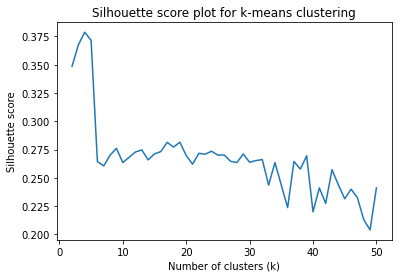

In [4]:
# Plot the silhouette score as a function of k
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette score plot for k-means clustering')
plt.show()

### (b) Determine which family/genus/species is the majority in each cluster

In [5]:
# Get the unique labels (families, genus, and species)
unique_families = np.unique(df['Family'])
unique_genus = np.unique(df['Genus'])
unique_species = np.unique(df['Species'])

# Iterate over each cluster and determine the majority label for each level
majority_families_lst = []
majority_genus_lst = []
majority_species_lst = []

for cluster in range(4):
    # Get the indices of samples in this cluster
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    
    # Get the true labels of the samples in this cluster
    cluster_labels = y.iloc[cluster_indices]
    
    # Count the occurrences of each label at the family level
    family_counts = np.zeros(len(unique_families))
    for i, family in enumerate(unique_families):
        family_counts[i] = np.sum(cluster_labels['Family'] == family)
    majority_family = unique_families[np.argmax(family_counts)]
    majority_families_lst.append(majority_family)
    
    # Count the occurrences of each label at the genus level
    genus_counts = np.zeros(len(unique_genus))
    for i, genus in enumerate(unique_genus):
        genus_counts[i] = np.sum(cluster_labels['Genus'] == genus)
    majority_genus = unique_genus[np.argmax(genus_counts)]
    majority_genus_lst.append(majority_genus)
    
    # Count the occurrences of each label at the species level
    species_counts = np.zeros(len(unique_species))
    for i, species in enumerate(unique_species):
        species_counts[i] = np.sum(cluster_labels['Species'] == species)
    majority_species = unique_species[np.argmax(species_counts)]
    majority_species_lst.append(majority_species)

In [6]:
for i in range(1,5):
    print(f'For Cluster {i}:')
    print(f'The majority family is {majority_families_lst[i-1]}')
    print(f'The majority genus is {majority_genus_lst[i-1]}')
    print(f'The majority species is {majority_species_lst[i-1]}')

For Cluster 1:
The majority family is 3
The majority genus is 0
The majority species is 1
For Cluster 2:
The majority family is 2
The majority genus is 3
The majority species is 5
For Cluster 3:
The majority family is 2
The majority genus is 3
The majority species is 4
For Cluster 4:
The majority family is 1
The majority genus is 1
The majority species is 2


### (c) Monte-Carlo Simulation (50 iterations), calculate the average Hamming distance, Hamming score, and Hamming loss

Hamming distance is the average number of positions in which two label sets differ.
Hamming score is the ratio of the number of correctly classified labels to the total number of labels.
Hamming loss is the fraction of labels that are incorrectly classified.

In [5]:
# First, we write a function to combine (a)-(c) together

def kmeans_clustering(X,y):
    
    # Get the best k
    k_values = range(2, 51) 
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    chosen_k = np.argmax(silhouette_scores) + 2
    kmeans = KMeans(n_clusters=chosen_k)
    kmeans.fit(X)
    print(f'Best K: {chosen_k}')
    
    # Determine which family/genus/species is the majority in each cluster
    unique_families = np.unique(y['Family'])
    unique_genus = np.unique(y['Genus'])
    unique_species = np.unique(y['Species'])

    majority_families_lst = []
    majority_genus_lst = []
    majority_species_lst = []

    for cluster in range(chosen_k):
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_labels = y.iloc[cluster_indices]

        # Count the occurrences of each label at the family level
        family_counts = np.zeros(len(unique_families))
        for i, family in enumerate(unique_families):
            family_counts[i] = np.sum(cluster_labels['Family'] == family)
        majority_family = unique_families[np.argmax(family_counts)]
        majority_families_lst.append(majority_family)

        # Count the occurrences of each label at the genus level
        genus_counts = np.zeros(len(unique_genus))
        for i, genus in enumerate(unique_genus):
            genus_counts[i] = np.sum(cluster_labels['Genus'] == genus)
        majority_genus = unique_genus[np.argmax(genus_counts)]
        majority_genus_lst.append(majority_genus)

        # Count the occurrences of each label at the species level
        species_counts = np.zeros(len(unique_species))
        for i, species in enumerate(unique_species):
            species_counts[i] = np.sum(cluster_labels['Species'] == species)
        majority_species = unique_species[np.argmax(species_counts)]
        majority_species_lst.append(majority_species)

    
    # Calculate the average Hamming distance, Hamming score, and Hamming loss
    y_pred = [np.zeros(len(y)), np.zeros(len(y)), np.zeros(len(y))]

    for i in range(4):
        # Get the indices of samples in this cluster
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        y_pred[0][cluster_indices] = majority_families_lst[i]
        y_pred[1][cluster_indices] = majority_genus_lst[i]
        y_pred[2][cluster_indices] = majority_species_lst[i]

    y_pred = np.array(y_pred).T
    hamming_distance = np.sum(np.sum(y != y_pred)) / len(y)
    hamming_loss = np.mean(np.not_equal(np.array(y), y_pred))
    hamming_score = 1 - hamming_loss
    
    return hamming_distance, hamming_loss, hamming_score

In [6]:
# Define Monte Carlo function:
def monteCarlo(times, X, y):
    
    hamming_distance_lst = []
    hamming_loss_lst = []
    hamming_score_lst = []
    
    for i in range(times):
        hamming_distance, hamming_loss, hamming_score = kmeans_clustering(X, y)
        hamming_distance_lst.append(hamming_distance)
        hamming_loss_lst.append(hamming_loss)
        hamming_score_lst.append(hamming_score)
        print("Attempt {} ~ Hamming Distance : {}, Hamming Loss : {}, Hamming Score : {}".format(i+1, hamming_distance, hamming_loss, hamming_score))
    
    return hamming_distance_lst, hamming_loss_lst, hamming_score_lst

Due to computational cost, the 50 iterations are executed in 5 times, with 10 iterations each.

In [7]:
hamming_distance_lst, hamming_loss_lst, hamming_score_lst = monteCarlo(10, X, y)

Best K: 4
Attempt 1 ~ Hamming Distance : 0.6668519805420431, Hamming Loss : 0.22228399351401437, Hamming Score : 0.7777160064859856
Best K: 4
Attempt 2 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 3 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 4 ~ Hamming Distance : 0.7357887421820709, Hamming Loss : 0.24526291406069028, Hamming Score : 0.7547370859393097
Best K: 4
Attempt 5 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 6 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 7 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 8 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.222422978920546

In [8]:
hamming_distance_lst2, hamming_loss_lst2, hamming_score_lst2 = monteCarlo(10, X, y)

Best K: 4
Attempt 1 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 2 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 3 ~ Hamming Distance : 0.7009034051424601, Hamming Loss : 0.23363446838082003, Hamming Score : 0.76636553161918
Best K: 4
Attempt 4 ~ Hamming Distance : 0.6669909659485754, Hamming Loss : 0.22233032198285846, Hamming Score : 0.7776696780171415
Best K: 4
Attempt 5 ~ Hamming Distance : 0.6674079221681724, Hamming Loss : 0.22246930738939077, Hamming Score : 0.7775306926106093
Best K: 4
Attempt 6 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 7 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 8 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.22242297892054

In [9]:
hamming_distance_lst3, hamming_loss_lst3, hamming_score_lst3 = monteCarlo(10, X, y)

Best K: 4
Attempt 1 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 2 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 3 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 4 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 5 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 6 ~ Hamming Distance : 0.6668519805420431, Hamming Loss : 0.22228399351401437, Hamming Score : 0.7777160064859856
Best K: 4
Attempt 7 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 8 ~ Hamming Distance : 0.735371785962474, Hamming Loss : 0.24512392865415797

In [10]:
hamming_distance_lst4, hamming_loss_lst4, hamming_score_lst4 = monteCarlo(10, X, y)

Best K: 4
Attempt 1 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 2 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 3 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 4 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 5 ~ Hamming Distance : 0.6657400972897846, Hamming Loss : 0.2219133657632615, Hamming Score : 0.7780866342367385
Best K: 4
Attempt 6 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 7 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 8 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, H

In [11]:
hamming_distance_lst5, hamming_loss_lst5, hamming_score_lst5 = monteCarlo(10, X, y)

Best K: 4
Attempt 1 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 2 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 3 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 4 ~ Hamming Distance : 0.6653231410701876, Hamming Loss : 0.22177438035672922, Hamming Score : 0.7782256196432707
Best K: 4
Attempt 5 ~ Hamming Distance : 0.7357887421820709, Hamming Loss : 0.24526291406069028, Hamming Score : 0.7547370859393097
Best K: 4
Attempt 6 ~ Hamming Distance : 0.6657400972897846, Hamming Loss : 0.2219133657632615, Hamming Score : 0.7780866342367385
Best K: 4
Attempt 7 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205467, Hamming Score : 0.7775770210794533
Best K: 4
Attempt 8 ~ Hamming Distance : 0.66726893676164, Hamming Loss : 0.2224229789205

In [17]:
# combine the 5 lists together
hamming_distance_lst_all = []
hamming_distance_lst_all.extend(hamming_distance_lst)
hamming_distance_lst_all.extend(hamming_distance_lst2)
hamming_distance_lst_all.extend(hamming_distance_lst3)
hamming_distance_lst_all.extend(hamming_distance_lst4)
hamming_distance_lst_all.extend(hamming_distance_lst5)

hamming_loss_lst_all = []
hamming_loss_lst_all.extend(hamming_loss_lst)
hamming_loss_lst_all.extend(hamming_loss_lst2)
hamming_loss_lst_all.extend(hamming_loss_lst3)
hamming_loss_lst_all.extend(hamming_loss_lst4)
hamming_loss_lst_all.extend(hamming_loss_lst5)

hamming_score_lst_all = []
hamming_score_lst_all.extend(hamming_score_lst)
hamming_score_lst_all.extend(hamming_score_lst2)
hamming_score_lst_all.extend(hamming_score_lst3)
hamming_score_lst_all.extend(hamming_score_lst4)
hamming_score_lst_all.extend(hamming_score_lst5)

In [18]:
# get the average and standard deviation
print("The average Hamming Distance is {}".format(np.mean(hamming_distance_lst_all)))
print("The standard deviation of simulation result is {}".format(np.std(hamming_distance_lst_all)))
print("The average Hamming Loss is {}".format(np.mean(hamming_loss_lst_all)))
print("The standard deviation of simulation result is {}".format(np.std(hamming_loss_lst_all)))
print("The average Hamming Score is {}".format(np.mean(hamming_score_lst_all)))
print("The standard deviation of simulation result is {}".format(np.std(hamming_score_lst_all)))

The average Hamming Distance is 0.6718637943015981
The standard deviation of simulation result is 0.016803063424687598
The average Hamming Loss is 0.22395459810053278
The standard deviation of simulation result is 0.005601021141562524
The average Hamming Score is 0.7760454018994671
The standard deviation of simulation result is 0.005601021141562524


## 3. ISLR 12.6.2

(a) Dendrogram with complete linkage (See dendrogram1.jpg)

![title](dendrogram1.jpg)

(b) Dendrogram with simple linkage (See dendrogram2.jpg)

![title](dendrogram2.jpg)

(c) We get two clusters: {1, 2} and {3, 4}.

(d) We get two clusters: {1, 2, 3} and {4}.

(e) Dendrogram equivalent to the one in (a) (See dendrogram3.jpg)

![title](dendrogram3.jpg)